<img src="assets/logo.png" width="800">

# Labor 08 - Lineáris regresszió regularizálása és Bias - Variancia
### Vízfolyás
A feladat első felében implementálásra kerül egy lineáris regresszió, hogy előre jelezhessük a kifolyt víz mennyiségét egy tartályból, annak alapján, hogy abban mennyi víz van. A feladat második felében megfigyeljük a tanulóalgoritmusok debuggolását és a bias illetve variancia típusú hibákat.

### 1: Importálás, adatok betöltése és vizualizálása

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as op

# keras imports for the dataset and building our neural network
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import regularizers
from keras import optimizers


from numpy.random import seed
seed(1)

data = loadmat("Lab8data.mat")                          # adatok betöltése
X_train = data["X"]                                     # adatok szerkesztése változókba
Y_train = data["y"]
X_val   = data["Xval"]
Y_val   = data["yval"]
X_test  = data["Xtest"]
Y_test  = data["ytest"]

del data
m,n = X_train.shape
print('Shape of X:', X_train.shape)
print('Shape of Y:', Y_train.shape)

Using TensorFlow backend.


Shape of X: (12, 1)
Shape of Y: (12, 1)


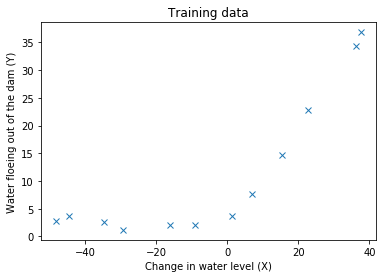

In [2]:
plt.plot(X_train,Y_train,'x')   # adatok megjelenítése
plt.title('Training data')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water floeing out of the dam (Y)')
plt.show()

A machine learning addig tart, ahol a deep learning elkezdődik. A határ az egy rétegű neurális háló. Ezzel a gondolattal térjünk vissza a L04-es laboron bevezetett büntetetéses eljáráshoz, immáron a neurális háló csomagokat használva. 

### Linearizált regresszió büntetéssel

A lineáris regressziónak megfelelő "hálót" hozunk létre, amely esetünkben 1 bemenő változóra fog épülni és 1 rétegből fog állni, amely 1 neuront fog tartalmazni. A BIAS tagot természetesen hozzá tesszük és kiegészítjük egy büntető taggal. Két gyakran használt büntetési eljárás az L1 és L2.

#### L2 regularizáció (Ridge regression)
$ C(w)=\frac{1}{2m}\sum_{i=1}^m(h_w(x^i)-y^i)^2+ \color{red}{\lambda\sum_{j=1}^nw_j^2} $

Ez a teknika jól alkalmazható a túltanulás megelőzésére. $\lambda $  megválasztására viszont figyelni kell, mivel túl nagyra választva előfordulhat az alul tanulás esete. 

#### L1 regularizáció (Lasso regression)
$ C(w)=\frac{1}{2m}\sum_{i=1}^m(h_w(x^i)-y^i)^2+ \color{red}{\lambda\sum_{j=1}^n|w_j|} $

Ez a teknika bizonyos együtthatókat 0-ra is redukálhat, így jól használható bemeneti paraméter szelektálásra.



Vizsgáljuk meg az alábbi háló összeállítást.

In [3]:
# Underfit Case
Lambda = 0
lr_rate = 0.005
epoch = 100

# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(1, input_shape=(1,), use_bias=True, kernel_regularizer=regularizers.l2(Lambda)))

# compiling the sequential model
sgd = optimizers.Adam(lr=lr_rate)
model.compile(loss='MSE', optimizer=sgd)

# training the model and saving metrics in history
history = model.fit(X_train, Y_train, epochs=epoch, validation_data=(X_val, Y_val), verbose = 2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 12 samples, validate on 21 samples
Epoch 1/100
 - 0s - loss: 682.8117 - val_loss: 761.7751
Epoch 2/100
 - 0s - loss: 676.3384 - val_loss: 755.8954
Epoch 3/100
 - 0s - loss: 670.8167 - val_loss: 749.7026
Epoch 4/100
 - 0s - loss: 665.0017 - val_loss: 743.3539
Epoch 5/100
 - 0s - loss: 659.0408 - val_loss: 736.9243
Epoch 6/100
 - 0s - loss: 653.0045 - val_loss: 730.4554
Epoch 7/100
 - 0s - loss: 646.9321 - val_loss: 723.9730
Epoch 8/100
 - 0s - loss: 640.8476 - val_loss: 717.4940
Epoch 9/100
 - 0s - loss: 634.7670 - val_loss: 711.0307
Epoch 10/100
 - 0s - loss: 628.7018 - val_loss: 704.5919
Epoch 11/100
 - 0s - loss: 622.6605 - val_loss: 698.1841
Epoch 12/100
 - 0s - loss: 616.6487 - val_loss: 691.8126
Epoch 13/100
 - 0s - loss: 610.6719 - val_loss: 685.4816
Epoch 14/100
 - 0s - loss: 604.7338 - val_loss: 679.1942
Epoch 15/100
 - 0s - loss: 598.8372 - val_loss:

Végezzük el a predikciót.

In [4]:
######################################################
Y_pred = model.predict(X_test)
######################################################

Majd rajzoltassuk ki a kapott eredményt.

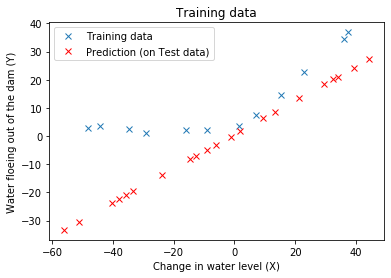

In [5]:
plt.plot(X_train,Y_train,'x')   # adatok megjelenítése
plt.plot(X_test,Y_pred,'x', color='red')   # adatok megjelenítése
plt.title('Training data')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water floeing out of the dam (Y)')
plt.legend(['Training data', 'Prediction (on Test data)'])
plt.show()

Az elvárásainknak és az egyszerű model felépítésünknek megfelelően egy lineáris becslést kaptunk, amely láthatóan nem megfelelően fedi az adatainkat. A beépített metrikákat felhasználva megvizsgálhatjuk a tanulás során a tanító és validáló adatokon a költség függvény lefutását. Ehhez először rajzoltassuk ki a megfelelő metrikákat.

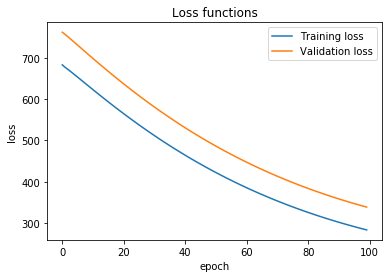

In [6]:
# plotting the metrics
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss functions')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'])

A grafikonon azt figyelhetjük meg, hogy mind a tanitó adatok költségfüggvény, mind a validációs adatok költségfüggvénye magas értéken maradt. Magasabban, mint ahogy azt elvárnánk egy jól működő prediktortól.
<img src="files/Pics/L08_HighBias.png" width="600">

Módosítsunk tehát a modellünkön, hogy jobb eredményt kapjunk.

# Poly Feature

A jobb eredmény eléréséhez több bemeneti paraméterre lesz szükségünk. Több paraméter előállításának egy lehetséges módja, ha a rendelkezésre álló paraméter polinomiális együtthatóit képezzük és további paraméterekként betápláljuk a neurális hálónkba.

Írjunk egy függvényt, amely megkapja bemenetként az aktuális mintákból álló mátrixot és feldúsítja azt a kívánt kitevőig a megfelelő oszlopokkal. $x => x, x^2, x^3 ... x^p$

In [7]:
def polyFeatures(X,p=9):
######################################################
    m=X.shape[0]
    X_poly = np.zeros((m,p))
    
    for i in range(1,m+1):
        for j in range(1,p+1):
            X_poly[i-1,j-1] = X[i-1]**j
######################################################    
    return X_poly

Ne felejtsük el lenormálni az értékeket, mivel a nagy kitevőjű tagok ellenkező esetben nagyon eltorzítanák a tanulást. Írjuk meg a normalizáló függvényt, ami bemenetként egy mintamátrixot kap és a normalizált mátrix mellett vissza adja az átlagok és szórások értékéti is egy-egy vektor formájában.

In [8]:
def featureNormalize(X):
######################################################   
    avg = np.mean(X, axis = 0)
    X_norm = X-avg
    std = np.std(X_norm, axis = 0,ddof = 1)
    X_norm = X_norm/std
######################################################    
    return X_norm,avg,std

Végezzük el a polinomiális változó dúsítást és a normálást is. 

$\color{red}{Fontos!}$

Amire figyeljünk, hogy a tanítás során csak a tanító adatokból származó információt szeretnénk felhasználni. Ez azt jelenti, hogy a test és validációs adatok normalizálását is a teszt adatokból számolt átlaggal és szórással kell elvégeznünk. Ellenkező esetben olyan adatokat szivárogatnánk vissza az algoritmusnak, amivel eltorzíthatnánk a tanulás eredményét. A validációs és teszt adatiank így tényleg függetlenek maradnak és az algoritmus csak a tanító adatokból nyert információval dolgozhat.

In [9]:
order=9

# X:
X_train_p = polyFeatures(X_train, order)                                # polynomial features
X_train_pn, mu, sigma = featureNormalize(X_train_p)                     # feature normalization
###################################################### 
# X_val:

X_val_p = polyFeatures(X_val, order)
X_val_pn = (X_val_p-mu)/sigma

# X_TESZT:
X_test_p = polyFeatures(X_test, order)
X_test_pn = (X_test_p-mu)/sigma
###################################################### 

print("""Expected Normalized Training Example for order=3 (approx.):
[-0.362 -0.755  0.182 ]""")
print('Normalized Training Example 1:\n',X_train_pn[0,:])

Expected Normalized Training Example for order=3 (approx.):
[-0.362 -0.755  0.182 ]
Normalized Training Example 1:
 [-0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792 -0.59087767
  0.3445158  -0.50848117  0.35954927]


Beállítjuk a szükséges paramétereket.

In [10]:
# Just Right Case
Lambda = 0
lr_rate = 0.01
epoch = 100
optim = optimizers.SGD(lr=lr_rate)

Mivel növeltük a változóink számát ezért a modellünket is módosítanunk kell. A bemeneti rétegnek passzolnia kell a megnövelt bementi mátrixunk méretéhez, viszont továbbra is csak egy kimenetet szeretnénk.


In [11]:
# building a linear stack of layers with the sequential model
model2 = Sequential()
###################################################### 
model2.add(Dense(order, input_shape=(order,), use_bias=True, kernel_regularizer=regularizers.l2(Lambda)))
model2.add(Dense(1))
###################################################### 

A modell architektúrájának kialakítás után a modelt lefordítjuk (compile) és definiáljuk a költség függvényt, valamit az optimizert. Itt is több lehetőség közül választhatunk, mint például az SGD vagy az ADAM.

In [12]:
# compiling the sequential model
#optim = optimizers.SGD(lr=lr_rate)
optim = optimizers.Adam(lr=lr_rate)
model2.compile(loss='MSE', optimizer=optim)

# training the model and saving metrics in history
history2 = model2.fit(X_train_pn, Y_train, epochs=epoch, validation_data=(X_val_pn, Y_val), verbose = 2)

Train on 12 samples, validate on 21 samples
Epoch 1/100
 - 0s - loss: 272.8830 - val_loss: 309.6862
Epoch 2/100
 - 0s - loss: 269.5784 - val_loss: 305.3512
Epoch 3/100
 - 0s - loss: 265.8645 - val_loss: 300.6464
Epoch 4/100
 - 0s - loss: 262.0154 - val_loss: 295.6749
Epoch 5/100
 - 0s - loss: 258.0985 - val_loss: 290.5688
Epoch 6/100
 - 0s - loss: 254.1446 - val_loss: 285.3910
Epoch 7/100
 - 0s - loss: 250.1691 - val_loss: 280.1696
Epoch 8/100
 - 0s - loss: 246.1806 - val_loss: 274.9186
Epoch 9/100
 - 0s - loss: 242.1852 - val_loss: 269.6428
Epoch 10/100
 - 0s - loss: 238.1862 - val_loss: 264.3401
Epoch 11/100
 - 0s - loss: 234.1845 - val_loss: 259.0028
Epoch 12/100
 - 0s - loss: 230.1778 - val_loss: 253.6200
Epoch 13/100
 - 0s - loss: 226.1616 - val_loss: 248.1799
Epoch 14/100
 - 0s - loss: 222.1293 - val_loss: 242.6722
Epoch 15/100
 - 0s - loss: 218.0736 - val_loss: 237.0889
Epoch 16/100
 - 0s - loss: 213.9872 - val_loss: 231.4250
Epoch 17/100
 - 0s - loss: 209.8635 - val_loss: 225.6

A modell tanítását követően végezzük ez a predikciót a teszt adatainkon.

In [13]:
###################################################### 
Y_pred2 = model2.predict(X_test_pn)
###################################################### 

Rajzoltassuk is ki a predikció eredményét.

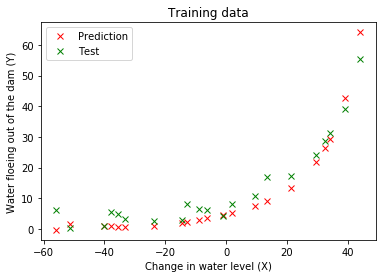

In [14]:
#plt.plot(X_train,Y_train,'x')   # adatok megjelenítése
plt.plot(X_test,Y_pred2,'x', color="red") 
plt.plot(X_test,Y_test,'x', color="green") 
plt.title('Training data')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water floeing out of the dam (Y)')
plt.legend(['Prediction', 'Test'])
plt.show()

Láthatjuk, hogy a bővített modellel sokkal jobb eredményt kaptunk, ami sokkal jobban illeszkedik az adatainkra. Az eredmény a metrikákban is tükröződik.

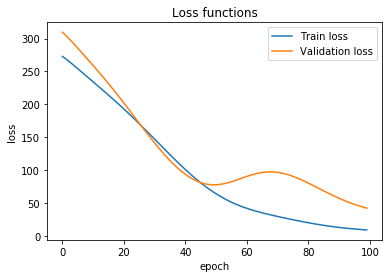

In [15]:
# plotting the metrics
fig = plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss functions')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'])

A tanító adatink költség függvénye és a validációs adataink költség függvénye is lényegesen alacsonyabb értéket ért el, mint az első próbálkozásunk alkalmavál.
<img src="files/Pics/L08_HighBias.png" width="600">

Bővíthetjük tovább a modellünket, illetve hangolhatjuk a hiper paramétereket, de vigyázzunk, nehogy a túl tanulás hibájába essünk, mint az alábbi modell esetében.

Esetünkben túl sok bemeneti paraméter választottunk és így futtattuk a tanítást.

In [16]:
#Overfit
Lambda = 0
lr_rate = 0.001
epoch = 100
order=12
optim = optimizers.Adam(lr=lr_rate)

In [17]:
# X:
X_train_p = polyFeatures(X_train, order)                                # polynomial features
X_train_pn, mu, sigma = featureNormalize(X_train_p)                     # feature normalization

# X_val:
X_val_p = polyFeatures(X_val, order)
X_val_pn = (X_val_p-mu)/sigma

# X_TESZT:
X_test_p = polyFeatures(X_test, order)
X_test_pn = (X_test_p-mu)/sigma

In [18]:
# building a linear stack of layers with the sequential model
model3 = Sequential()
model3.add(Dense(order, input_shape=(order,), use_bias=True, kernel_regularizer=regularizers.l2(Lambda)))
model3.add(Dense(1))

In [19]:
# compiling the sequential model
optim = optimizers.SGD(lr=lr_rate)
model3.compile(loss='MSE', optimizer=optim)

# training the model and saving metrics in history
history3 = model3.fit(X_train_pn, Y_train, epochs=epoch, validation_data=(X_val_pn, Y_val), verbose = 2)

Train on 12 samples, validate on 21 samples
Epoch 1/100
 - 0s - loss: 276.4300 - val_loss: 321.6675
Epoch 2/100
 - 0s - loss: 271.6718 - val_loss: 316.1202
Epoch 3/100
 - 0s - loss: 267.1379 - val_loss: 310.7780
Epoch 4/100
 - 0s - loss: 262.7841 - val_loss: 305.5963
Epoch 5/100
 - 0s - loss: 258.5741 - val_loss: 300.5382
Epoch 6/100
 - 0s - loss: 254.4780 - val_loss: 295.5725
Epoch 7/100
 - 0s - loss: 250.4704 - val_loss: 290.6731
Epoch 8/100
 - 0s - loss: 246.5305 - val_loss: 285.8172
Epoch 9/100
 - 0s - loss: 242.6401 - val_loss: 280.9855
Epoch 10/100
 - 0s - loss: 238.7839 - val_loss: 276.1612
Epoch 11/100
 - 0s - loss: 234.9482 - val_loss: 271.3295
Epoch 12/100
 - 0s - loss: 231.1216 - val_loss: 266.4775
Epoch 13/100
 - 0s - loss: 227.2936 - val_loss: 261.5939
Epoch 14/100
 - 0s - loss: 223.4551 - val_loss: 256.6686
Epoch 15/100
 - 0s - loss: 219.5981 - val_loss: 251.6930
Epoch 16/100
 - 0s - loss: 215.7154 - val_loss: 246.6595
Epoch 17/100
 - 0s - loss: 211.8006 - val_loss: 241.5

In [20]:
Y_pred3 = model3.predict(X_test_pn)

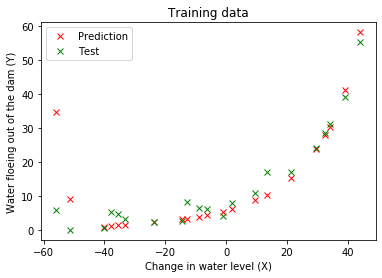

In [21]:
plt.plot(X_test,Y_pred3,'x', color="red") 
plt.plot(X_test,Y_test,'x', color="green") 
plt.title('Training data')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water floeing out of the dam (Y)')
plt.legend(['Prediction', 'Test'])
plt.show()

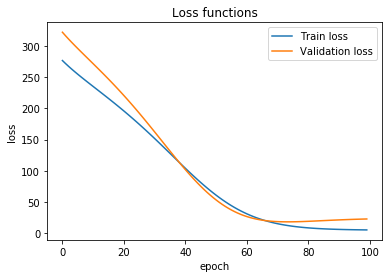

In [22]:
# plotting the metrics
fig = plt.figure()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss functions')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'])

Látható, hogy a a modell túlságpsan rátanul a tanító mintákra és a 60. epoch után a tanító minták költségfüggvénye ugyan tovább csökken, viszont a validációs mintákon elért eredmény elkezd romlani. Ez azt jelenti, hogy bár a tanító minták költség függvénye bőven egy elvárt szint alatt teljesít, a validációs és teszt minták költség függvénye magasan az elvárt eredmény fölött lesz. "Nyílik az olló", nagy lesz a különbség a két költségfüggvény között.
<img src="files/Pics/L08_HighVariance.png" width="600">

### Összefoglalva néhány tipp a különböző hibák kezelésére

Alul tanulás ("Underfitting", High Bias probléma) esetén:
- Több bemeneti paraméter hozzáadás a modellhez (akár független akar polinomiális).
- $\lambda$ paraméter csökkentése, azaz kevésbé büntetjük.
- Epoch szám növelése.
- $\alpha$ (tanulási ráta, learning rate) növelése.

Túl tanulás ("Overfitting", HighVariance probléma) esetén:
- Kevesebb bemeneti paraméter.
- $\lambda$ paraméter növelése, azaz jobban büntetjük.
- Több tanuló minta.
- $\alpha$ (tanulási ráta, learning rate) csökkentése.

<div style="text-align: right">Ez a laborgyakorlat felhasznál elemeket Andrew Ng Machine Learning c. kurzusából.</div>